In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import pandas as pd
import datetime
now = datetime.datetime.now

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading and Preprocessing

In [ ]:
# Load the data
fatigue_df = pd.read_csv('../Data/Carbon_Torsion_PI.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
0,1,320,28100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,3.321334e+04
1,1,320,32100,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,3.321334e+04
2,1,310,90400,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,6.773490e+04
3,1,310,119000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,6.773490e+04
4,1,300,263000,550,825,0.05,0.03,0.0,33,23,68,0.35,0.21,0.77,0.021,0.022,0.01,0.01,0.02,1.413961e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,36,320,88300,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,3.969058e+04
374,36,310,117000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,9.258966e+04
375,36,300,144000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.220432e+05
376,36,300,321000,650,660,0.06,0.00,0.0,33,23,62,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.220432e+05


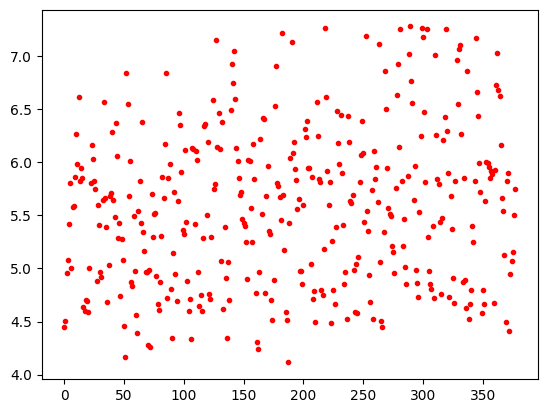

In [ ]:
# Scatter Plot
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life
0,360,550,825,0.10,0.03,0.01,33,22,63,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02,1.615986e+04
1,320,550,610,0.07,0.00,0.03,33,21,62,0.26,0.23,0.51,0.018,0.024,0.01,0.02,0.01,8.962672e+03
2,350,550,1270,0.12,0.01,0.00,33,22,66,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.778024e+04
3,290,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08,7.521639e+03
4,280,600,1270,0.07,0.02,0.00,33,27,72,0.25,0.18,0.44,0.009,0.017,0.08,0.12,0.08,3.701477e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,360,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,9.787854e+06
374,310,600,1270,0.08,0.01,0.00,33,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,6.547304e+06
375,290,600,825,0.10,0.03,0.01,33,25,66,0.44,0.24,0.82,0.021,0.021,0.03,0.02,0.02,8.935626e+06
376,350,550,660,0.06,0.00,0.00,33,55,79,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,4.144169e+07


In [ ]:
# Convert the features into floats
features = features.astype('float64')

# Model Training

In [ ]:
# rmse loss
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Run # 1 Fold # 1
Training time: 0:00:37.311594


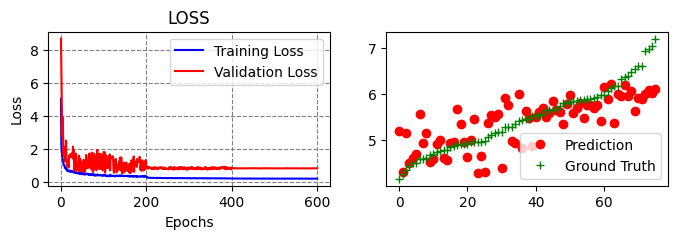

Pearson CC: 0.7590023278250497
R2 score: 0.5612326523841562
RMSE: 0.4671374719380566
MAE: 0.7150061019127946
********************
Run # 1 Fold # 2
Training time: 0:00:35.456816


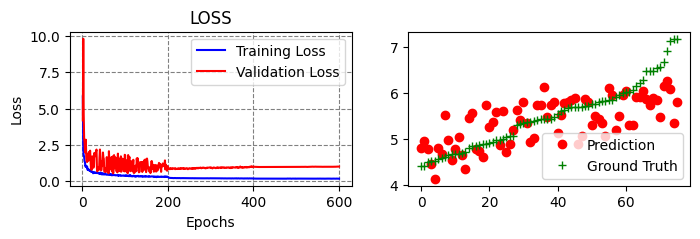

Pearson CC: 0.6759063825893181
R2 score: 0.4332686762840039
RMSE: 0.5287600014193978
MAE: 0.6948729529317336
********************
Run # 1 Fold # 3


Training time: 0:00:35.394069


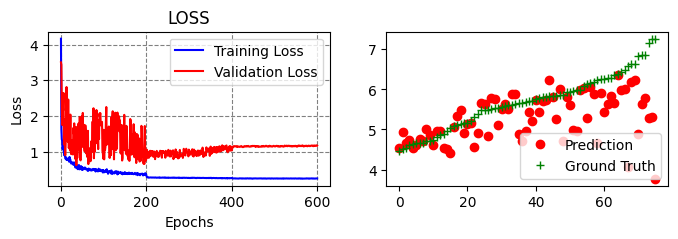

Pearson CC: 0.4176345937585581
R2 score: -0.30487199209297744
RMSE: 0.7938581275923795
MAE: 0.7821569140865816
********************
Run # 1 Fold # 4
Training time: 0:00:35.719328


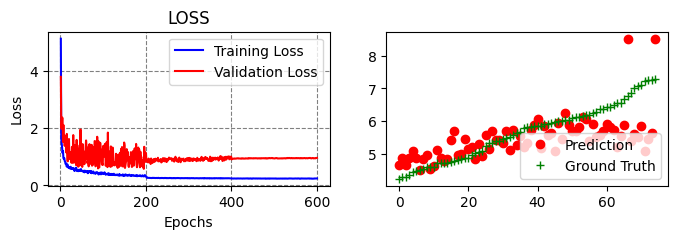

Pearson CC: 0.6131806689458192
R2 score: 0.29982462149530553
RMSE: 0.7083353516359838
MAE: 0.8643906921566997
********************
Run # 1 Fold # 5
Training time: 0:00:35.505190


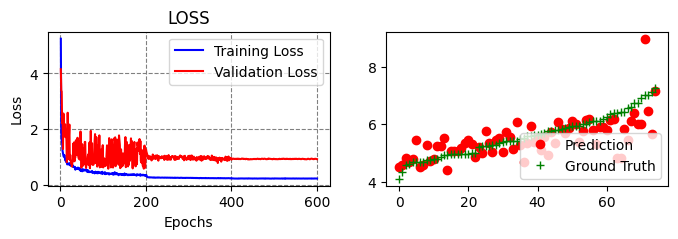

Pearson CC: 0.7062296262665281
R2 score: 0.4237647907873121
RMSE: 0.5446658415643172
MAE: 0.7662067669625551
********************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # define DNN
            model = Sequential()
            model.add(Input(shape=(18,)))
            model.add(Dense(1000,activation='relu'))
            model.add(Dense(200,activation='relu'))
            model.add(Dense(40,activation='relu'))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer= 'RMSprop', loss=root_mean_squared_error)

            # learning rate scheduler
            import math
            INITIAL_LEARNING_RATE = 0.01
            EPOCHS_NUM = 600
            def lr_step_decay(epoch, lr):
                drop_rate = 0.1
                epochs_drop = 200
                return INITIAL_LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))

            callbacks=[LearningRateScheduler(lr_step_decay, verbose=0)]

            # Fit model
            t = now()
            history = model.fit(x_train, y_train, batch_size=16, epochs=EPOCHS_NUM,
                                validation_split=0.2, verbose=0, callbacks=callbacks)
            print('Training time: %s' % (now() - t))

            # Plot the loss and the predictions
            train_loss = history.history['loss']
            val_loss = history.history['val_loss']
            epochsn = np.arange(1, len(train_loss)+1,1)
            plt.figure(figsize=(8, 2))
            plt.subplot(1,2,1)
            plt.plot(epochsn,train_loss, 'b', label='Training Loss')
            plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
            plt.grid(color='gray', linestyle='--')
            plt.legend()
            plt.title('LOSS')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.subplot(1,2,2)
            y_pred_test = model.predict(x_test, verbose=0)
            plt.plot(y_pred_test, 'ro', label='Prediction')
            plt.plot(np.array(y_test), 'g+', label='Ground Truth')
            plt.legend(loc=4)
            plt.show()

            # Evaluate metrics
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred_test))[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.759002,0.561233,0.467137,0.715006
1,0.675906,0.433269,0.528760,0.694873
2,0.417635,-0.304872,0.793858,0.782157
3,0.613181,0.299825,0.708335,0.864391
4,0.706230,0.423765,0.544666,0.766207


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.634391,0.118191,0.282644,0.305183,0.608551,0.122263,0.764527,0.059313
